## initiation and preparation
___

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf, erfc, erfcinv
from scipy.optimize import minimize

from mpl_toolkits.mplot3d import Axes3D
from cell_library import loadparams

In [5]:
TC = np.load('data\\ExpTF_exc_Nstp40_new.npy').T
RE = np.load('data\\ExpTF_inh_Nstp40_new.npy').T
ve = np.linspace(0, 40, 40)
vi = np.linspace(0, 170, 40)

vve, vvi = np.meshgrid(ve, vi)

In [7]:
RS = np.load('data\\ExpTF_cortex_exc_Nstp21.npy').T
FS = np.load('data\\ExpTF_cortex_inh_Nstp21.npy').T
RS2 = np.load('data\\ExpTF_cortex_exc_Nstp21_single.npy').T
FS2 = np.load('data\\ExpTF_cortex_inh_Nstp21_single.npy').T
ve = np.linspace(0, 150, 21)
vi = np.linspace(0, 150, 21)

vve, vvi = np.meshgrid(ve, vi)

Text(0, 0.5, 'vout TC')

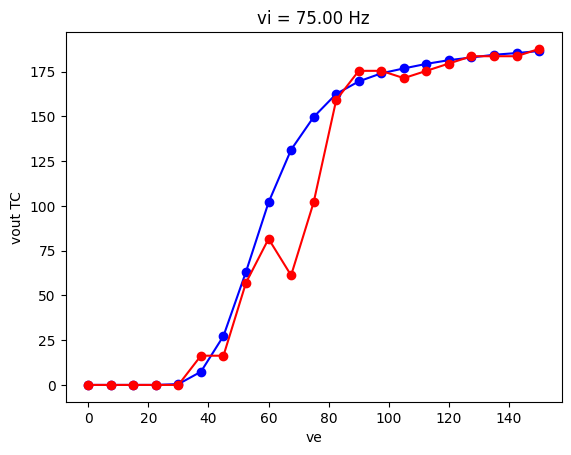

In [10]:
i = 10 # choose inhibitory input

plt.plot(ve, RS[i], '-ob')
plt.plot(ve, RS2[i], '-or')
plt.title(f'vi = {vi[i]:.2f} Hz')
plt.xlabel('ve')
plt.ylabel('vout TC')

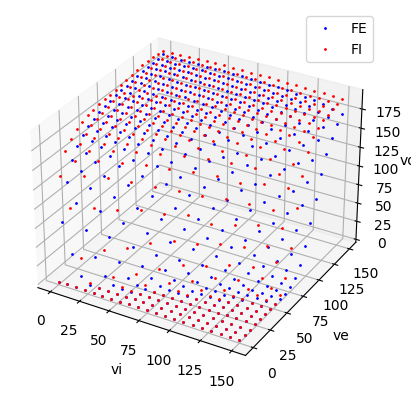

In [4]:
ax = plt.axes(projection='3d')
ax.plot3D(vvi.flatten(), vve.flatten(), RS.flatten(), 'ob', markersize=1,label='FE')
ax.plot3D(vvi.flatten(), vve.flatten(), FS.flatten(), 'or', markersize=1,label='FI')

ax.set_xlabel('vi')
ax.set_ylabel('ve')
ax.set_zlabel('vout')
ax.legend();

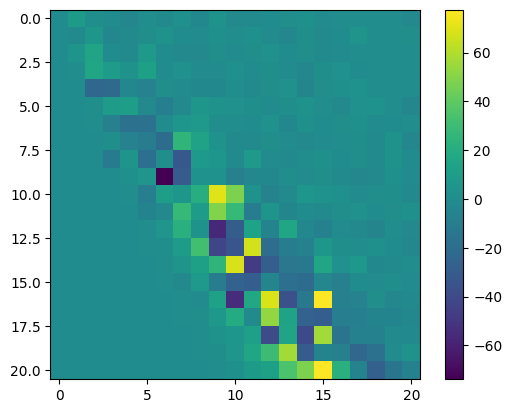

In [11]:
plt.imshow(RS-RS2)
plt.colorbar()

In [6]:
# params = loadparams('thalamus_ACh')
params = loadparams('cortex')
# params = loadparams('cortex_farzin')

In [7]:
params['RS']

{'P': 0,
 'Nexc': 400,
 'Ninh': 100,
 'Qe': 1.5e-09,
 'Qi': 5e-09,
 'Cm': 2e-10,
 'El': -0.065,
 'Gl': 1e-08,
 'Tw': 0.2,
 'a': 4e-09,
 'b': 4e-11,
 'Ti': 0.005,
 'Te': 0.005,
 'Ee': 0,
 'Ei': -0.08}

## theory and functions
___

$ \mu_{Ge}(\nu_e,\nu_i)=\nu_eK_e\tau_eQ_e $

$ \mu_{Gi}(\nu_e,\nu_i)=\nu_iK_i\tau_iQ_i $

$ \mu_G(\nu_e,\nu_i)=\mu_{Ge}+\mu_{Gi}+g_L $

$ \tau_m^\text{eff}(\nu_e,\nu_i)=\frac{C_m}{\mu_G} $

$ \mu_V=\frac{\mu_{Ge}E_e+\mu_{Gi}E_i+g_LE_L-w}{\mu_G} $

$ \mu_V=\frac{\mu_{Ge}E_e+\mu_{Gi}E_i+g_LE_L-\nu_\text{out}\tau_wb+aE_L}{\mu_G+a} $

$ \sigma_V(\nu_e,\nu_i)=\sqrt{\sum_sK_s\nu_s\frac{(U_s\cdot\tau_s)^2}{2(\tau_m^\text{eff}+\tau_s)}} $

$ \tau_V(\nu_e,\nu_i)=\left(\frac{\sum_sK_s\nu_s(U_s\cdot\tau_s)^2}{\sum_sK_s\nu_s(U_s\cdot\tau_s)^2/(\tau_m^\text{eff}+\tau_s)}\right) $

$ U_s=\frac{Q_s}{\mu_G}(E_s-\mu_V) $

$ \nu_\text{out}=\frac{1}{2\tau_V}\cdot\text{Erfc}\left(\frac{V_\text{thr}^\text{eff}-\mu_V}{\sqrt{2}\sigma_V}\right) $

$ V_\text{thr}^\text{eff}(\mu_V,\sigma_V,\tau_V^N)=P_0+\sum_{x\in\{\mu_V,\sigma_V,\tau_V^N\}}P_x\cdot\left(\frac{x-x^0}{\delta x^0}\right)+\sum_{x,y\in\{\mu_V,\sigma_V,\tau_V^N\}^2}P_{xy}\cdot\left(\frac{x-x^0}{\delta x^0}\right)\left(\frac{y-y^0}{\delta y^0}\right) $

$ \text{MPF}:(\nu_e,\nu_i)\longrightarrow(\mu_V,\sigma_V,\tau_V,\tau_V^N) $

In [8]:
def MPF(typ,fexc,finh,fout):

    p = params[ typ ]
    P,Nexc,Ninh,Qe,Qi,Cm,El = p.P,p.Nexc,p.Ninh,p.Qe,p.Qi,p.Cm,p.El
    a,b,Tw,Gl,Te,Ti,Ee,Ei = p.a,p.b,p.Tw,p.Gl,p.Te,p.Ti,p.Ee,p.Ei

    fexc[fexc<1e-9]=1e-9
    fe = fexc*Nexc
    finh[finh<1e-9]=1e-9
    fi = finh*Ninh


    muGi = Qi*Ti*fi
    muGe = Qe*Te*fe
    muG = Gl+muGe+muGi
    muV = (muGe*Ee+muGi*Ei+Gl*El - fout*Tw*b + a*El)/(muG+a)
    
    
    muGn = muG/Gl
    Tm = Cm/muG
    
    Ue =  Qe/muG*(Ee-muV)
    Ui = Qi/muG*(Ei-muV)

    sV = np.sqrt(fe*(Ue*Te)*(Ue*Te)/2./(Te+Tm)+fi*(Ui*Ti)*(Ui*Ti)/2./(Ti+Tm))

    Tv = ( fe*(Ue*Te)*(Ue*Te) + fi*(Qi*Ui)*(Qi*Ui)) /( fe*(Ue*Te)*(Ue*Te)/(Te+Tm) + fi*(Qi*Ui)*(Qi*Ui)/(Ti+Tm) )
    TvN = Tv*Gl/Cm

    return muV, sV, Tv, TvN

In [9]:
# test MPF function
typ = 'RS'
xe, xi = 4, 30

m, s, t, _ = MPF(typ, np.array([xe]), np.array([xi]), 0)
print(f'MPF_{typ}: (ve={xe}, vi={xi})Hz -> (mu={m[0]*1e3:.2f}, sigma={s[0]*1e3:.2f}, tau={t[0]*1e3:.2f})mV')

MPF_RS: (ve=4, vi=30)Hz -> (mu=-68.42, sigma=2.25, tau=7.06)mV


In [31]:
#====== calculate MPF for TC/RE =======

#-choose here the neuron typ:
typ = 'FS'
#---------------------------

exec(f'FF={typ}')
muV, sV, Tv, TvN = MPF(typ, vve, vvi, FF)

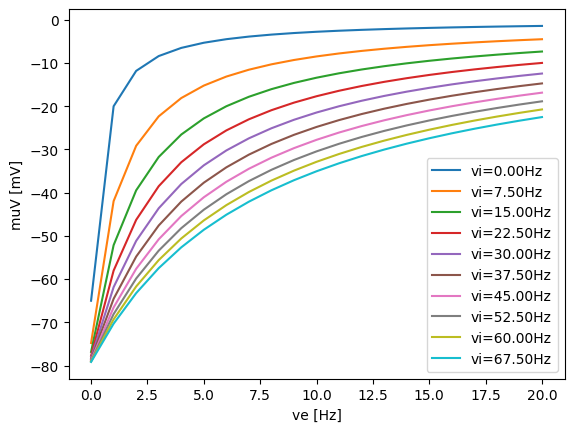

In [32]:
for i in range(10):
    plt.plot(muV[i]*1e3,label=f'vi={vi[i]:.2f}Hz')

plt.xlabel('ve [Hz]')
plt.ylabel('muV [mV]')
plt.legend();

In [33]:
def pheV(fout, muV, sV, Tv):
    fout[fout<0]=1e-9
    Tv[Tv<0]=1e-9
    return np.sqrt(2)*sV * erfcinv( 2*Tv*fout ) + muV # Zerlaut 2017
    # return np.sqrt(2)*sV * erfcinv( Tv*fout ) + muV # to widen the definition range

Text(0, 0.5, 'Veff [mV]')

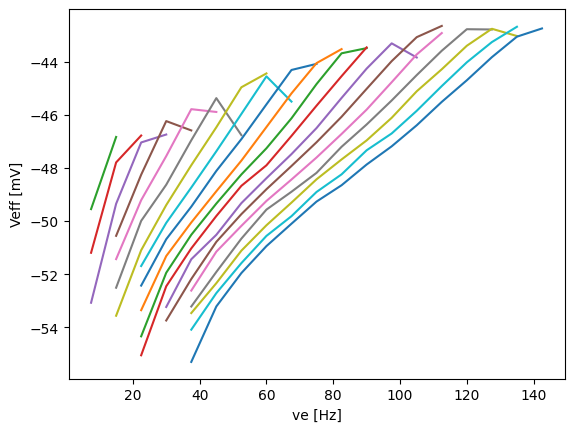

In [34]:
#====== calculate phenomenological V_thr^eff ======
Veff = pheV(FF, muV, sV, Tv)

for i in range(len(vi)):
    plt.plot(ve, Veff[i]*1e3,label=f'vi={vi[i]:.2f}Hz')

plt.xlabel('ve [Hz]')
plt.ylabel('Veff [mV]')
# plt.legend(loc=(1.2,-1.2));

In [35]:
# remove dimension so that no NaN entries are there anymore
# ONLY important for fitting the Vthr

if typ=='TC': idx = '[15:38,8:35]'
elif typ=='RE': idx = '[20:40,10:]'
elif typ=='RS': idx = '[8:,7:]'
elif typ=='FS': idx = '[10:,5:11]'

exec(f"Veff_fit = Veff{idx}")
# exec(f"TC_fit = TC{idx}")
# exec(f"RE_fit = RE{idx}")
exec(f"muV_fit = muV{idx}")
exec(f"sV_fit = sV{idx}")
exec(f"Tv_fit = Tv{idx}")
exec(f"TvN_fit = TvN{idx}")
Veff_fit.shape

(11, 6)

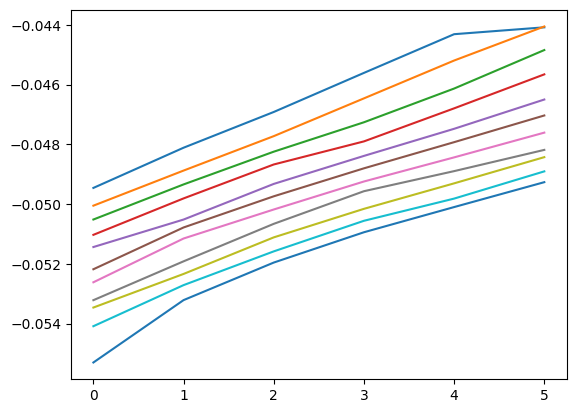

In [36]:
plt.plot(Veff_fit.T);

## fitting and results
___

#### fitting first order to find correct global minimum

In [37]:
# calculating the effective threshold potential with a general second order polynomial of the membrane moments (mu,sigma,tau)

def Vthre(P, muV, sV, TvN):
    # normalizing moments:
    muV0 = -60e-3;
    DmuV0 = 10e-3;
    sV0 = 4e-3;
    DsV0 = 6e-3;
    TvN0 = 0.5;
    DTvN0 = 1.;
    
    # first order polynomial
    Vo1 = P[0] + P[1]*(muV-muV0)/DmuV0 + P[2]*(sV-sV0)/DsV0 + P[3]*(TvN-TvN0)/DTvN0
    # second order polynomial
    Vo2 = P[4]*((muV-muV0)/DmuV0)*((muV-muV0)/DmuV0) + P[5]*(muV-muV0)/DmuV0*(sV-sV0)/DsV0 + P[6]*(muV-muV0)/DmuV0*(TvN-TvN0)/DTvN0 + P[7]*((sV-sV0)/DsV0)*((sV-sV0)/DsV0) + P[8]*(sV-sV0)/DsV0*(TvN-TvN0)/DTvN0  + P[9]*((TvN-TvN0)/DTvN0)*((TvN-TvN0)/DTvN0);

    return Vo1 + Vo2
    

In [38]:
# fitting first order Vthr on the phenomenological threshold space

def Res(P): return np.mean( (Veff_fit - Vthre(np.concatenate([P,[0]*6]), muV_fit, sV_fit, TvN_fit))**2 )

res = minimize(Res, [Veff_fit.mean(),1e-3,1e-3,1e-3], method='nelder-mead', tol=1e-20, options={'disp':True,'maxiter':20000})
# res = minimize(Res, [Veff_fit.mean(),1e-3,1e-3,1e-3], method='SLSQP', tol=1e-32, options={'disp':True,'maxiter':20000})

P1 = np.array(res.x)
print(P1)

[-0.06163238  0.00388968  0.00790037 -0.0489589 ]


C:\Users\jover\AppData\Local\Temp\ipykernel_24808\1219303345.py:5: RuntimeWarning: Maximum number of iterations has been exceeded.
  res = minimize(Res, [Veff_fit.mean(),1e-3,1e-3,1e-3], method='nelder-mead', tol=1e-20, options={'disp':True,'maxiter':20000})


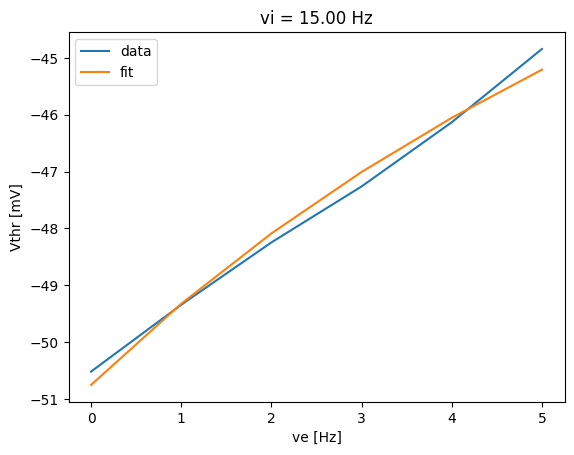

In [39]:
# checking the fit...

# choose vi:
i=2

plt.title(f'vi = {vi[i]:.2f} Hz')

plt.plot(Veff_fit[i]*1e3, label='data')
plt.plot(Vthre(np.concatenate([P1,[0]*6]), muV_fit, sV_fit, TvN_fit)[i]*1e3, label='fit')
plt.xlabel('ve [Hz]')
plt.ylabel('Vthr [mV]')
plt.legend();


___
skippable 

In [155]:
# fit the second order parameters on Vthre ( not necessary most of the time!!!! -> SKIP )
def Res(P): return np.mean( (Veff_fit - Vthre(np.concatenate([P1,P]), muV_fit, sV_fit, TvN_fit))**2 )

res = minimize(Res, [1e-9]*6, method='nelder-mead', tol=1e-15, options={'disp':True,'maxiter':20000})
# res = minimize(Res, [0]*6, method='SLSQP', options={'ftol':1e-20,'disp':True,'maxiter':20000})

P2 = np.array(res.x)
print(P2)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 1332
         Function evaluations: 2202
[ 2.12321162e-05 -5.51879833e-03  4.75010955e-03 -1.24710725e-02
 -1.17091516e-02  2.03790312e-02]


In [156]:
P = np.concatenate([P1,P2])

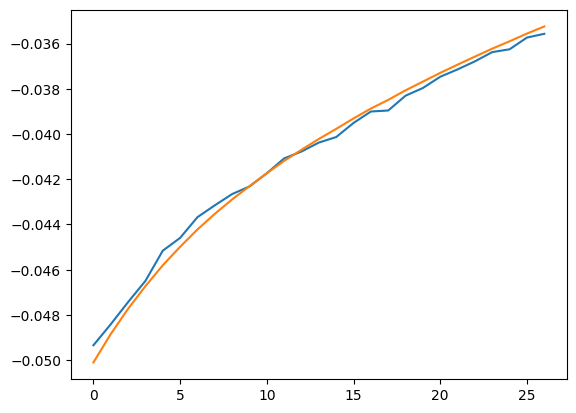

In [158]:
i =10
plt.plot(Veff_fit[i])
plt.plot(Vthre(P, muV_fit, sV_fit, TvN_fit)[i])

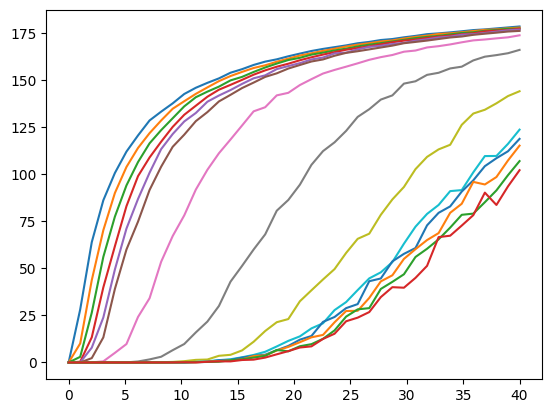

In [163]:
# choose a subspace to fit the firing rate and transfer function ( not necessary BUT produces better results most of the time )
# IMPPORTANT if a subspace in firing rate input is more interesting or badly fitted without doing this ...

red = [0,5,8,9,10,11,12,13,14,15,19,20,21,22,23,24,25,30,39]
# rid = [0,20,30,35,36,37,38,39]
rid = [0,1,2,3,4,5,10,20,30,35,36,37,38,39]
# rid = [0,1,2,3,4,5,6,7,8,9,10]

plt.plot(ve,FF[rid].T);

skippable
___

In [40]:
# the transfer function
def TF(P, muV, sV, Tv, TvN):
    fout = 1/(2*Tv) * erfc( (Vthre(P, muV, sV, TvN) - muV)/(np.sqrt(2)*sV) )
    
    # fout = np.where(fout<0, 1e-9, fout)
    fout[fout<0]=0
    return fout

In [41]:
def Res(P):
    # return np.mean( (TC_fit - TF(P, muV_fit, sV_fit, Tv_fit, TvN_fit))**2 )
    return np.mean( (FF - TF(P, muV, sV, Tv, TvN))**2 )
    # return np.mean( (FF[rid] - TF(P, muV[rid], sV[rid], Tv[rid], TvN[rid]))**2 )

# res = minimize(Res, P, method='nelder-mead', tol=1e-20, options={'disp':True,'maxiter':40000})
res = minimize(Res, np.concatenate([P1,[1e-6]*6]), method='nelder-mead', tol=1e-20, options={'disp':True,'maxiter':20000})
# res = minimize(Res, P, method='SLSQP', options={'ftol':1e-20,'disp':True,'maxiter':40000})

PP = np.array(res.x)
print(PP)

[-0.05027908  0.00150934  0.00395822  0.00358273  0.00063094 -0.00592857
  0.00351012 -0.00291324  0.00071171  0.00329202]


C:\Users\jover\AppData\Local\Temp\ipykernel_24808\3552097889.py:7: RuntimeWarning: Maximum number of iterations has been exceeded.
  res = minimize(Res, np.concatenate([P1,[1e-6]*6]), method='nelder-mead', tol=1e-20, options={'disp':True,'maxiter':20000})


In [166]:
TF(PP, muV, sV, Tv, TvN)[10]

array([8.10674165e-237, 1.89975196e-011, 8.83455573e-004, 2.34357773e-001,
       2.78624696e+000, 1.07442153e+001, 2.25387825e+001, 3.77543668e+001,
       5.17880862e+001, 6.64085708e+001, 8.02878250e+001, 9.21064266e+001,
       1.02853201e+002, 1.12269233e+002, 1.20418750e+002, 1.27284454e+002,
       1.33084005e+002, 1.38328689e+002, 1.42532004e+002, 1.46329206e+002,
       1.49461915e+002, 1.52190987e+002, 1.54559641e+002, 1.56648260e+002,
       1.58484829e+002, 1.60108751e+002, 1.61555549e+002, 1.62859140e+002,
       1.64039439e+002, 1.65109038e+002, 1.66094552e+002, 1.66996644e+002,
       1.67835332e+002, 1.68614099e+002, 1.69340858e+002, 1.70022695e+002,
       1.70665437e+002, 1.71272024e+002, 1.71846576e+002, 1.72391676e+002])

vi = 112.50Hz


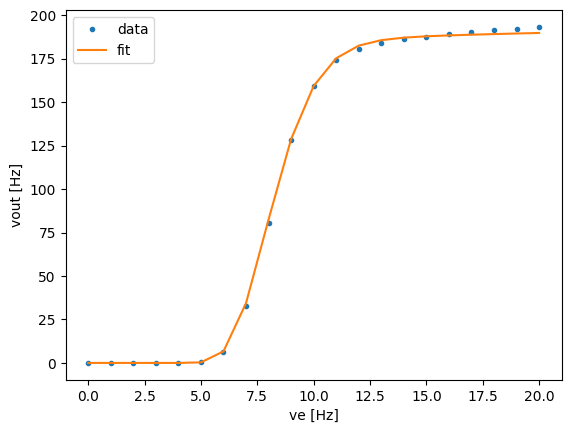

In [47]:
# compare fit

# choose vi...
i =15

print(f'vi = {vi[i]:.2f}Hz')

plt.plot(FF[i], 'o', ms=3, label='data')
plt.plot(TF(PP, muV, sV, Tv, TvN)[i], label='fit')

plt.xlabel('ve [Hz]')
plt.ylabel('vout [Hz]')
plt.legend();


In [30]:
#===== SAVE fitted parameters ======

np.save(f'data\\FITparams_{typ}_exp.npy', PP)

___
___
#### END (other ideas stuff beyond here + unimaginable horrors beyond your imagination)
___
___

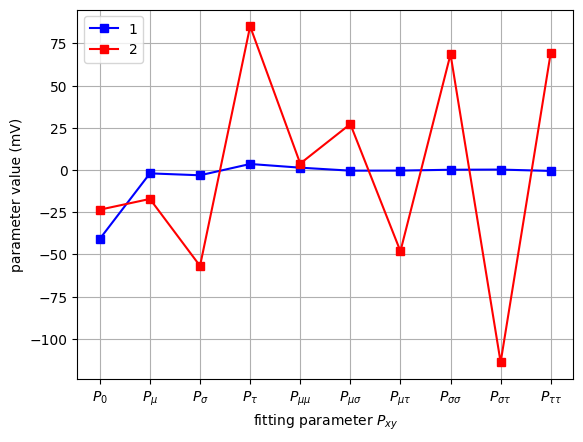

In [25]:
# pZ=np.load("C:\VSCode\DB_comparison\mf\data\FS-cell_CONFIG1_fit.npy")[[0,1,2,3,5,8,9,6,10,7]]
pppp2=np.load('data\\NEW6params_RE.npy')*1e3
pppp3=np.load('data\\NEW5params_RE.npy')*1e3
# pppp2=np.load('data\\NEW4params_RE.npy')
# pppp3=np.load('data\\NEW6params_RE.npy')
plt.plot(pppp2,'s-b',label='1')
plt.plot(pppp3,'s-r',label='2')
labels = ['$P_0$','$P_{\mu}$','$P_{\sigma}$','$P_{\\tau}$' , '$P_{\mu\mu}$','$P_{\mu\sigma}$','$P_{\mu\\tau}$','$P_{\sigma\sigma}$','$P_{\sigma\\tau}$','$P_{\\tau\\tau}$']
plt.xticks(range(len(labels)),labels);
plt.ylabel('parameter value (mV)')
plt.xlabel('fitting parameter $P_{xy}$')
plt.grid()
plt.legend()
# plt.savefig('gfx\\fitparams.png',dpi=200,bbox_inches='tight')

___

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc
from mytools import ornstein_uhlenbeck

In [3]:
typ='TC'
PP = np.load(f'data\\NEW6params_{typ}.npy')

In [4]:
def TF2(P,fexc,finh,adapt, Nexc,Ninh,Qe,Qi,Cm,El, noise=1):

    fe = fexc*Nexc
    fi = finh*Ninh

    fe+=1e-9;
    fi+=1e-9;
    
    muGi = Qi*Ti*fi;
    muGe = Qe*Te*fe;
    muG = Gl+muGe+muGi;
    muV = (muGe*Ee+muGi*Ei+Gl*El-adapt)/muG;
    # muV = (muGe*Ee+muGi*Ei+Gl*El - fout*Tw*b + a*El)/(muG+a);
    
    
    muGn = muG/Gl;
    Tm = Cm/muG;
    
    Ue =  Qe/muG*(Ee-muV);
    Ui = Qi/muG*(Ei-muV);
    
    sV = np.sqrt(fe*(Ue*Te)*(Ue*Te)/2./(Te+Tm)+fi*(Ui*Ti)*(Ui*Ti)/2./(Ti+Tm));

    sV*=noise
    
    
    fe+=1e-9;
    fi+=1e-9;

    Tv = ( fe*(Ue*Te)*(Ue*Te) + fi*(Qi*Ui)*(Qi*Ui)) /( fe*(Ue*Te)*(Ue*Te)/(Te+Tm) + fi*(Qi*Ui)*(Qi*Ui)/(Ti+Tm) );
    TvN = Tv*Gl/Cm;
    
    muV0=-60e-3;
    DmuV0 = 10e-3;
    sV0 =4e-3;
    DsV0= 6e-3;
    TvN0=0.5;
    DTvN0 = 1.;

    vthre = P[0] + P[1]*(muV-muV0)/DmuV0 + P[2]*(sV-sV0)/DsV0 + P[3]*(TvN-TvN0)/DTvN0 \
    + P[4]*((muV-muV0)/DmuV0)*((muV-muV0)/DmuV0) + P[5]*(muV-muV0)/DmuV0*(sV-sV0)/DsV0 + P[6]*(muV-muV0)/DmuV0*(TvN-TvN0)/DTvN0 + P[7]*((sV-sV0)/DsV0)*((sV-sV0)/DsV0) + P[8]*(sV-sV0)/DsV0*(TvN-TvN0)/DTvN0 + P[9]*((TvN-TvN0)/DTvN0)*((TvN-TvN0)/DTvN0);


    frout = 1/(2*Tv) * erfc( (vthre - muV)/(np.sqrt(2)*sV) )
    
    return frout;

Gl=10*1.e-9
Tw=200*1.e-3
b=0.01*1e-9

Ti=5*1.e-3
Te=5*1.e-3
Ee=0
Ei=-80*1.e-3

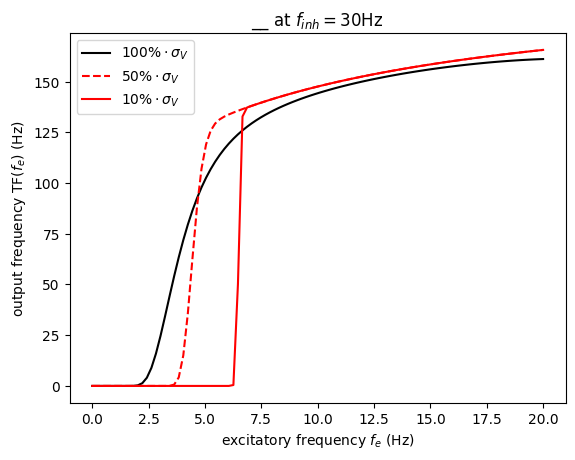

In [25]:
fe = np.linspace(0,20,100)
fi = 30
if typ=='TC':
    fout1 = TF2(PP,fe,fi,0, Nexc=800,Ninh=25,Qe=1e-9,Qi=6e-9,Cm=160e-12,El=-65e-3)
    fout2 = TF2(PP,fe,fi,0, Nexc=800,Ninh=25,Qe=1e-9,Qi=6e-9,Cm=160e-12,El=-55e-3, noise=.3)
    fout3 = TF2(PP,fe,fi,0, Nexc=800,Ninh=25,Qe=1e-9,Qi=6e-9,Cm=160e-12,El=-55e-3, noise=.1)
# PP2=PP.copy()
# PP2[2] = RE[2]
# PP2[5]*=2
# PP2[8] = RE[8]
# PP2[9] = RE[9]
if typ=='RE':
    fout1 = TF2(PP,fe,fi,0, Nexc=400,Ninh=150,Qe=4e-9,Qi=1e-9,Cm=200e-12,El=-75e-3)
    fout2 = TF2(PP,fe,fi,0, Nexc=400,Ninh=150,Qe=4e-9,Qi=1e-9,Cm=200e-12,El=-75e-3, noise=0.5)
    fout3 = TF2(PP,fe,fi,0, Nexc=400,Ninh=150,Qe=4e-9,Qi=1e-9,Cm=200e-12,El=-75e-3, noise=0.1)

plt.plot(fe,fout1,'black', label='$100\%\cdot\sigma_V$')
plt.plot(fe,fout2,'--r', label='$50\%\cdot\sigma_V$')
plt.plot(fe,fout3,'r', label='$10\%\cdot\sigma_V$')

plt.legend()
plt.xlabel("excitatory frequency $f_e$ (Hz)")
plt.ylabel("output frequency TF$(f_e)$ (Hz)")
plt.title("__ at $f_{inh}=30$Hz");
# plt.savefig("NoiseTF_TC_new.png", dpi=250)

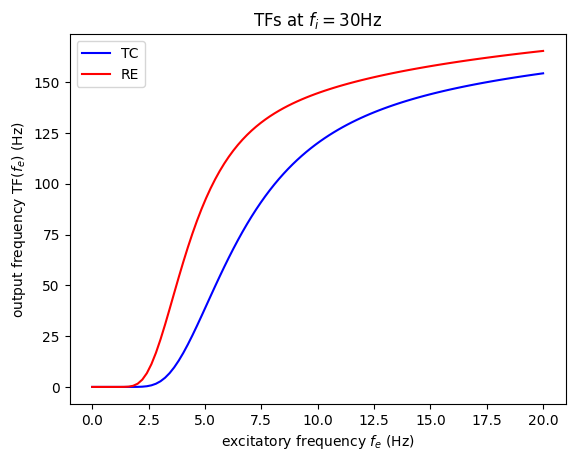

In [19]:
fe = np.linspace(0,20,100)
fi = 30
fout1 = TF2(np.load('data\\NEW6params_TC.npy'),fe,fi,0, Nexc=800,Ninh=25,Qe=1e-9,Qi=6e-9,Cm=160e-12,El=-65e-3)
fout2 = TF2(np.load('data\\NEW6params_RE.npy'),fe,fi,0, Nexc=400,Ninh=150,Qe=4e-9,Qi=1e-9,Cm=200e-12,El=-75e-3)

plt.plot(fe,fout1,'b', label='TC')
plt.plot(fe,fout2,'r', label='RE')

plt.legend()
plt.xlabel("excitatory frequency $f_e$ (Hz)")
plt.ylabel("output frequency TF$(f_e)$ (Hz)")
plt.title(f"TFs at $f_i=30$Hz");
# plt.savefig("TF.png", dpi=250)

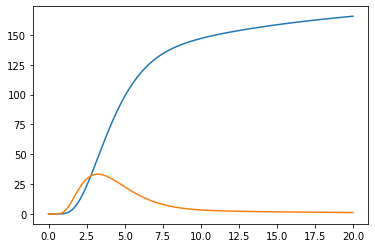

In [8]:
fe = np.linspace(0,20,100)
fi = 30
# plt.plot(fi,TF2(PP,fe,fi,0, Nexc=800,Ninh=25,Qe=1e-9,Qi=6e-9,Cm=160e-12,El=-65e-3))
plt.plot(fe,TF2(PP,fe,fi,0, Nexc=400,Ninh=150,Qe=4e-9,Qi=1e-9,Cm=200e-12,El=-75e-3))

def der(fe,fi,dfe=1e-5,dfi=0):
    # return (TF2(PP,fe+dfe/2,fi+dfi/2,0, Nexc=800,Ninh=25,Qe=1e-9,Qi=6e-9,Cm=160e-12,El=-65e-3) - TF2(PP,fe-dfe/2,fi-dfi/2,0, Nexc=800,Ninh=25,Qe=1e-9,Qi=6e-9,Cm=160e-12,El=-65e-3))/(dfe+dfi)
    return (TF2(PP,fe+dfe/2,fi+dfi/2,0, Nexc=400,Ninh=150,Qe=4e-9,Qi=1e-9,Cm=200e-12,El=-75e-3) - TF2(PP,fe-dfe/2,fi-dfi/2,0, Nexc=400,Ninh=150,Qe=4e-9,Qi=1e-9,Cm=200e-12,El=-75e-3))/(dfe+dfi)
plt.plot(fe,der(fe,fi))